**Block 1 (Packages and Setup)**
- install wbdata
- import all necessary libraries
- load data (wbdata or local file)

In [ ]:
# 1.1 - installing wbdata (colab based)
!pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.2.1 which is incompatible.
bigframes 2.21.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.


In [ ]:
# 1.2 - import packages
import wbdata
import datetime
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [ ]:
# 1.3 - download data (unemployment, cpi inflation)
country_group = [
    "MWI", "MLI", "MLT", "NLD", "GMB", "GBR", "USA", "ARE", "AFG", "AUT",
    "AUS", "BFA", "BDI", "BEN", "DNK", "ETH", "DJI", "FIN", "FRA", "DEU",
    "IRL", "JPN", "LSO", "LUX", "LBR", "NER", "NOR", "PAK", "SVN", "SGP",
    "ESP", "GIN", "GNB", "HKG", "ISL", "CHE", "SWE", "ISR", "KOR", "MOZ",
    "TCD", "TZA", "SLE", "MDG", "CAF", "HTI", "SEN", "BEL", "CAN", "SSD",
    "CZE", "NGA", "MRT", "TGO", "ITA", "CYP", "PNG", "RWA", "UGA", "CIV",
    "GRC", "POL", "EST", "SAU", "BHR", "LTU", "SLB", "CMR", "ZMB", "KHM"
    ]

indicators = {
    "FP.CPI.TOTL.ZG": "CPI Inflation",
    "SL.UEM.TOTL.ZS": "Unemployment Rate",
    "FD.RES.LIQU.AS.ZS": "Bank Liquid to Assets"
    }

date_10 = (datetime.datetime(2010, 1, 1), datetime.datetime(2010, 12, 31))
date_13 = (datetime.datetime(2013, 1, 1), datetime.datetime(2013, 12, 31))
date_23 = (datetime.datetime(2023, 1, 1), datetime.datetime(2023, 12, 31))
date_18 = (datetime.datetime(2018, 1, 1), datetime.datetime(2018, 12, 31))
df = wbdata.get_dataframe(indicators, country=country_group, date=date_23)
df.reset_index(inplace=True)

In [ ]:
# 1.4 - workaround in case of wbdata API issues (either execute 1.3 or 1.4)
df_alternative = pd.read_csv(".csv")

**Block 2 (Data Cleaning and Transformation)**
- Convert DataFrames to np.ndarray
- Ensure feature vectors are ready for analysis (drop non-numeric entries etc.)
- Build dictionaries between data, data index, and country names
- Initial visualization to get a sense of the data

In [ ]:
# 2.1 - Extract and convert data; drop rows with missing entries
extracted_data = df[['CPI Inflation', 'Unemployment Rate']].to_numpy()

cleaned_data = np.vstack([
    row for row in extracted_data if np.all(np.vectorize(np.isfinite)(row))
    ])

In [ ]:
# 2.2 - Create dictionaries between countries, indexes, and the data
index_vec = np.arange(len(country_group))

country_dict = {
    country: index for country, index in zip(country_group, index_vec)
    }

index_dict = {
    index: country for index, country in zip(index_vec, country_group)
    }

In [ ]:
# 2.3 - Data Normalization
scaler = StandardScaler()
cleaned_normalized_data = scaler.fit_transform(cleaned_data)

n = len(cleaned_normalized_data)
data = cleaned_normalized_data

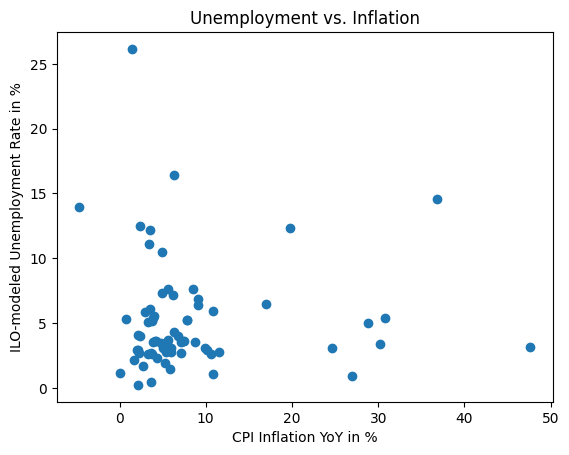

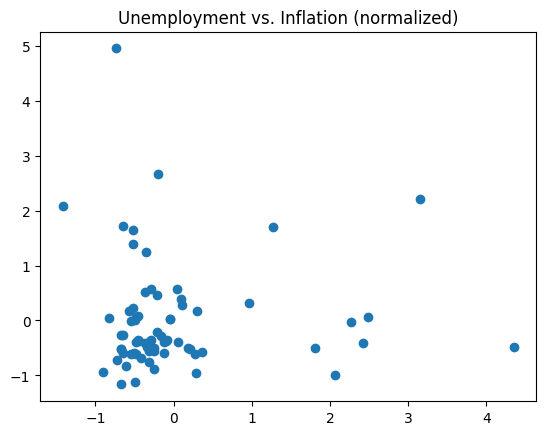

In [ ]:
# 2.5 - Initial visualization
x = extracted_data[:, 0]
y = extracted_data[:, 1]
x_trans = cleaned_normalized_data[:,0]
y_trans = cleaned_normalized_data[:,1]

plt.scatter(x, y)
plt.xlabel("CPI Inflation YoY in %")
plt.ylabel("ILO-modeled Unemployment Rate in %")
plt.title("Unemployment vs. Inflation")
plt.show()

plt.scatter(x_trans, y_trans)
plt.title("Unemployment vs. Inflation (normalized)")
plt.show()

**Block 3 (Determine the Number of Clusters)**
- compute Gaussian kernel and kernel width from data (Scott's rule)
- compute similariry matrix, degree matrix, Laplacian matrices
- analyze spectrum of the normalized Laplacian to use eigengap heuristic for the number of clusters

*See NAME.pdf for details on the underlying theory (eigengaps, kernel, Scott's rule). *

In [ ]:
# 3.1 - Function to obtain width matrix from given data using Scott's rule
def scotts_2d(arr: np.ndarray):
  lenx = len(arr)
  if arr.shape != (lenx, 2):
    raise ValueError("Only for 2D data!")
  arr_std = np.std(arr, axis=0)
  sigma1 = arr_std[0]
  sigma2 = arr_std[1]
  matrix = np.zeros((2, 2))
  matrix[0,0] = 1/(sigma1 * lenx**(-1/6))**2
  matrix[1,1] = 1/(sigma2 * lenx**(-1/6))**2
  return matrix

In [ ]:
# 3.2 - Function to compute Gaussian kernel from width matrix and data
def gaussian_2d(arr: np.ndarray, H: np.ndarray):
  lenx = len(arr)
  if arr.shape != (2,):
    raise ValueError("Only for 2D data!")
  if H.shape != (2, 2):
    raise ValueError("Bandwidth matrix out of bounds!")
  return np.exp(- arr.T @ H @ arr)

In [ ]:
# 3.3 - Compute similarity, degree, and Laplacian matrices
W = np.zeros((n, n))

for i in range(n):
  for j in range(n):
    W[i, j] = gaussian_2d((data[i] - data[j]), scotts_2d(data))

D = np.zeros((n,n))
for  i in range(n):
  D[i, i] = sum(W[i, :])

D_inv_sqrt = np.zeros((n,n))
for  i in range(n):
  D_inv_sqrt[i,i] = 1/(np.sqrt(D[i,i]))

L = D - W
L_norm = D_inv_sqrt @ L @ D_inv_sqrt

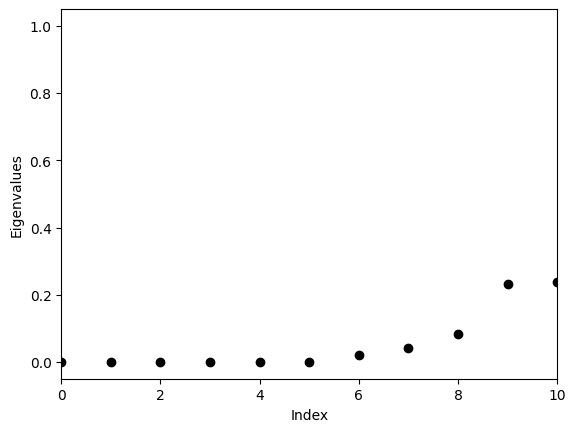

gap2 is 1.3070757948919998e-10
gap3 is 1.629355154940483e-07
gap4 is 2.8861149511543827e-07
gap5 is 0.00027378791400976425
gap6 is 0.0001787807267841215
gap7 is 0.020580220989754358
gap8 is 0.019828555142211046
gap9 is 0.04167146271041844


In [ ]:
# 3.4 - Compute eigengaps and plot eigenvalues of the normalized Laplacian
lambdas, v = eigh(L_norm)
indices = np.arange(n)
constant = np.zeros(n)

plt.scatter(indices, lambdas, marker = 'o', color = 'black')
plt.xlabel('Index')
plt.ylabel('Eigenvalues')
plt.xlim(0, 10)
plt.show()

eigengaps = [lambdas[k] - lambdas[k-1] for k in range(1,9)]
for k, gap in enumerate(eigengaps, start=2):
  print(f"gap{k} is {gap}")

**Block 4 (Clustering Analysis)**
- compute the clusters
- visualize clusters wirth colorized scatterplot and table chart

In [ ]:
# 4.1 - Spectral Clustering, n_clusters based on eigengap analysis
clustering = SpectralClustering(n_clusters= 5, affinity='precomputed')
labels = clustering.fit_predict(W)

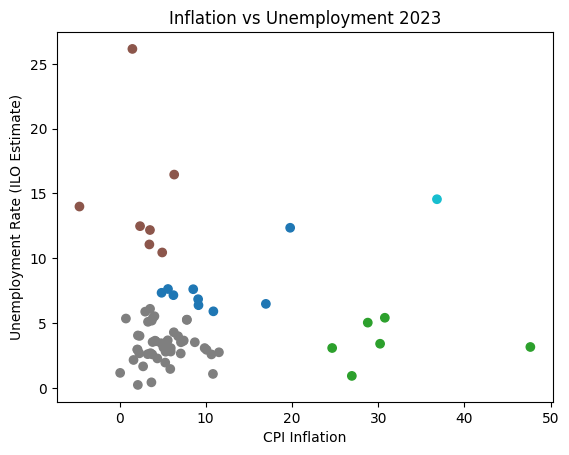

In [ ]:
# 4.2 - Visualize clusters with a scatterplot
plt.scatter(extracted_data[:,0], extracted_data[:,1], c=labels, cmap="tab10")
plt.ylabel("Unemployment Rate (ILO Estimate)")
plt.xlabel("CPI Inflation")
plt.title("Inflation vs Unemployment 2023")
plt.show()

In [ ]:
# 4.3 - Comprehensive list of cluster assignments
result = [[index_dict[i], label] for i, label in enumerate(labels)]
df_result = pd.DataFrame(result, columns=["Country", "Cluster"])
df_result

,Country,Cluster
0,MWI,2
1,MLI,3
2,MLT,3
3,NLD,3
4,GMB,1
...,...,...
65,LTU,3
66,SLB,3
67,CMR,3
68,ZMB,3
